In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Datos

Contamos con dos sets de datos. Uno de ajuste, que usaremos para el algoritmo de cuadrados minimos. El otro set de datos se usara como una validacion para ver que tan bien la curva resultante se ajusta a otro conjunto de datos de la misma distribucion.

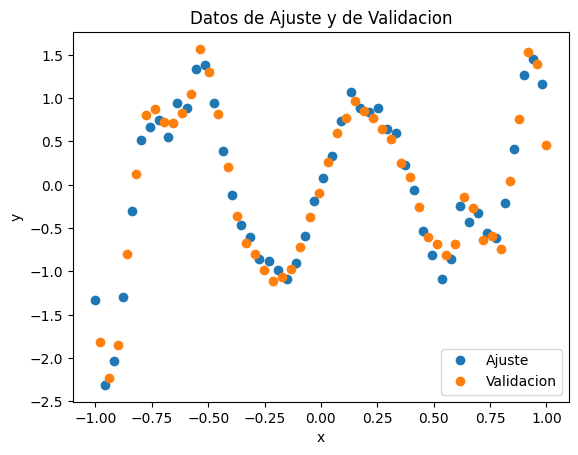

In [30]:
def leer_datos(archivo):
    datos = np.reshape(np.fromfile(archivo, dtype='f', sep=' '), (-1, 2))
    return (datos[:, 0], datos[:, 1])

X_ajuste, y_ajuste = leer_datos('./datos/ajuste.txt')
X_val, y_val = leer_datos('./datos/validacion.txt')

plt.plot(X_ajuste, y_ajuste, 'o', label='Ajuste')
plt.plot(X_val, y_val, 'o', label='Validacion')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Datos de Ajuste y de Validacion')
plt.savefig('graficos/datos.png')
plt.show()

Definimos las funciones de ECM que nos permitiran medir el error entre los datos predecidos y los datos reales, tanto para los datos de ajuste como para los datos de validacion.

Ya que el algoritmo de cuadrados minimos nos devuelve el $\beta$ predecido, lo utilizamos para construir los $y$ predecidos al calcular el ECM utilizando regresion polinomial con polinomios de Legendre.

In [31]:
def ECM(beta_pred, grado, Xs=X_val, ys=y_val):
  X = np.polynomial.legendre.legvander(Xs, grado)
  y_pred = (beta_pred.T@X.T).T

  return np.mean((y_pred-ys)**2)

def ECM_val(beta_pred, grado):
  return ECM(beta_pred, grado)

def ECM_ajuste(beta_pred, grado):
  return ECM(beta_pred, grado, Xs=X_ajuste, ys=y_ajuste)

# Cuadrados minimos SVD

Definimos entonces el algoritmo de cuadrados minimos utilizando SVD.

Para esto necesitamos tomar la base de polinomios de Legendre, encontrar su descomposicion SVD, y reducir S para quedarnos con las filas no nulas y U para poder computar la expresion de ajuste.

In [32]:
def cuadrados_minimos_svd(Xs, ys, grado):
    X = np.polynomial.legendre.legvander(Xs, grado)

    U, sigma, VT = np.linalg.svd(X)

    S = np.diag(sigma)
    U_reducida = U[:, :grado+1]

    beta_pred = VT.T@np.linalg.inv(S)@U_reducida.T@ys
    y_pred = (beta_pred.T@X.T).T

    return (beta_pred, y_pred)

Veamos el resultado de utilizar el algoritmo para un grado dado. Por ejemplo podemos usar grado 20

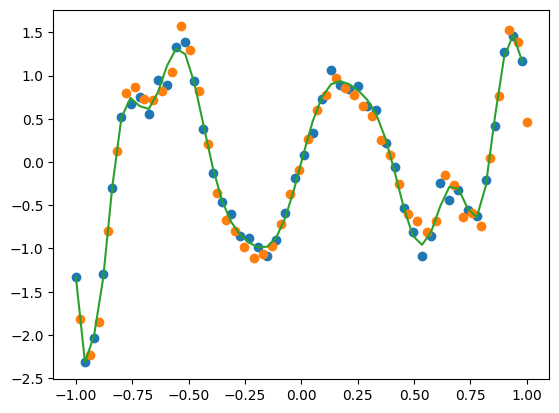

0.08646901


In [33]:
grado = 20
beta_pred, y_pred = cuadrados_minimos_svd(X_ajuste, y_ajuste, grado)
plt.plot(X_ajuste,y_ajuste,'o')
plt.plot(X_val,y_val,'o')
plt.plot(X_ajuste,y_pred,'-')
plt.show()
print(ECM_val(beta_pred, grado))

# Cuadrados minimos SVD con regularizacion

Utilizar el algoritmo anterior puede resultar en coeficientes muy elevados cuando utilicemos grados muy grandes.

Vamos a utilizar entonces una solucion modificada que utiliza regularizacion. La regularizacion consta de agregar un parametro que penalice los coeficientes elevados. Al derivar las ecuaciones nuevamente y expresarla en terminos de SVD nos queda el siguiente algoritmo modificado.

In [34]:
def cuadrados_minimos_svd_reg(Xs, ys, grado, lamb):
    X = np.polynomial.legendre.legvander(Xs, grado)

    U, sigma, VT = np.linalg.svd(X)

    S = np.diag(sigma)
    U_reducida = U[:, :grado+1]

    lambda_id = np.identity(S.shape[0]) * lamb

    beta_pred = VT.T@S@np.linalg.inv((S**2) + lambda_id)@U_reducida.T@ys
    y_pred = (beta_pred.T@X.T).T

    return (beta_pred, y_pred)

Veamos nuevamente el resultado de aplicar el algoritmo para grado 20, y usando algun lambda arbitrario.

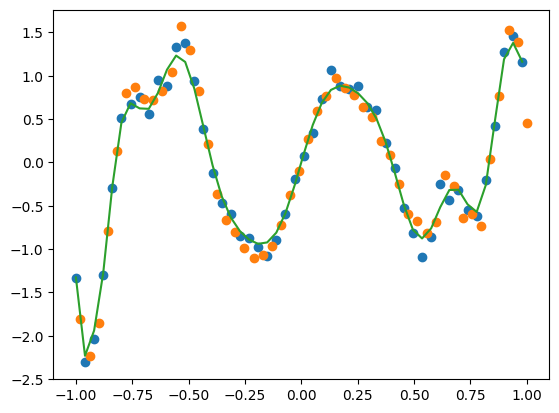

0.021058322982162796


In [35]:
grado = 20
lamb = 0.2
beta_pred, y_pred = cuadrados_minimos_svd_reg(X_ajuste, y_ajuste, grado, lamb)
plt.plot(X_ajuste,y_ajuste,'o')
plt.plot(X_val,y_val,'o')
plt.plot(X_ajuste,y_pred,'-')
plt.show()
print(ECM_val(beta_pred, grado))

Podemos observar que el ECM de validacion es menor al caso sin regularizacion

# Experimentacion

Queremos explorar como la variacion de estos parametros (grado del polinomio de Legendre y valor de lambda) afectan el ajuste a los datos de validacion.

Para eso definimos la siguiente funcion, que dado un rango de grados y de lambdas computa una matriz con los ECM de validacion para cada par grado y lambda.

In [36]:
def minimizar_lambda_grado(rango_grados, rango_lambdas):
    min_grado = 0
    min_lamb = 0
    min_ecm = 1e6

    resultados = np.zeros((len(rango_grados), len(rango_lambdas)))
    for i_grado in range(len(rango_grados)):
        for j_lamb in range(len(rango_lambdas)):
            grado = rango_grados[i_grado]
            lamb = rango_lambdas[j_lamb]

            beta_pred, y_pred = cuadrados_minimos_svd_reg(X_ajuste, y_ajuste, grado, lamb)

            ecm = ECM_val(beta_pred, grado)

            if (ecm < min_ecm):
                min_grado = grado
                min_lamb = lamb
                min_ecm = ecm

            resultados[i_grado, j_lamb] = ecm
    
    return (resultados, min_grado, min_lamb, min_ecm)


Los grados son numeros enteros que van hasta 50, asi que ese sera nuestro rango de grados.

Los lambdas por su lado pueden ser numeros de punto flotante, por lo que tomamos una muestra de 500 valores entre 0 y 1

In [37]:
rango_grados = np.arange(50)
rango_lambdas = np.linspace(0, 1, 500)

resultados, min_grado, min_lamb, min_ecm = minimizar_lambda_grado(rango_grados, rango_lambdas)

Minimo ECM de validacion:  0.013056801780639692
ECM de ajuste:  0.005130632298287327
lambda:  0.02004008016032064
grado:  32


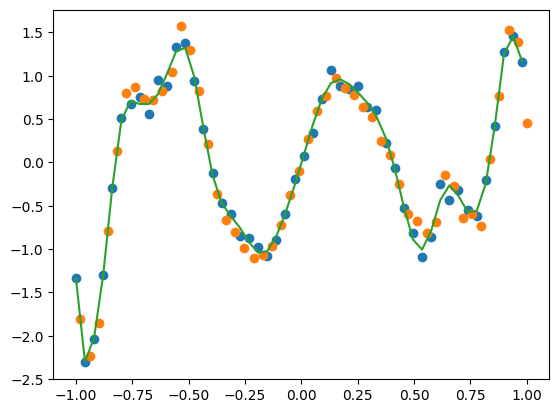

In [38]:
beta_pred, y_pred = cuadrados_minimos_svd_reg(X_ajuste, y_ajuste, min_grado, min_lamb)
print('Minimo ECM de validacion: ', min_ecm)
print('ECM de ajuste: ', ECM_ajuste(beta_pred, min_grado))
print('lambda: ', min_lamb)
print('grado: ', min_grado)

plt.plot(X_ajuste,y_ajuste,'o')
plt.plot(X_val,y_val,'o')
plt.plot(X_ajuste,y_pred,'-')

plt.show()

El resultado nos muestra que el grado que minimiza el ECM de validacion es $32$, con un lambda de regularizacion $\approx 0.02$

Vemos que parece ajustar bastante bien tanto a los datos de validacion como a los de ajuste, y obtenemos valores bajos de ECM.

Veamos como se compara esto a utilizar el grado obtenido como optimo sin regularizacion

ECM de validacion sin regularizacion:  122572.16
ECM de ajuste sin regularizacion:  0.004393501


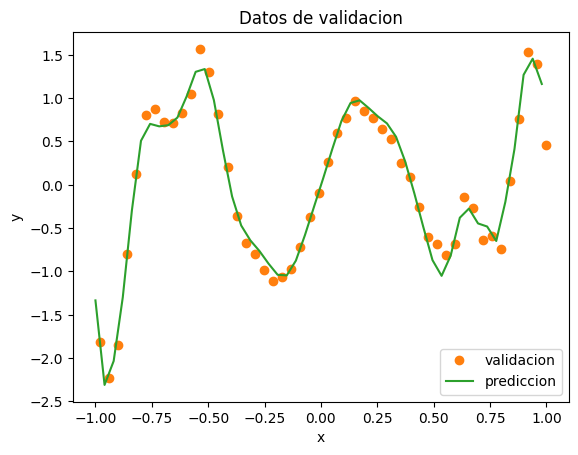

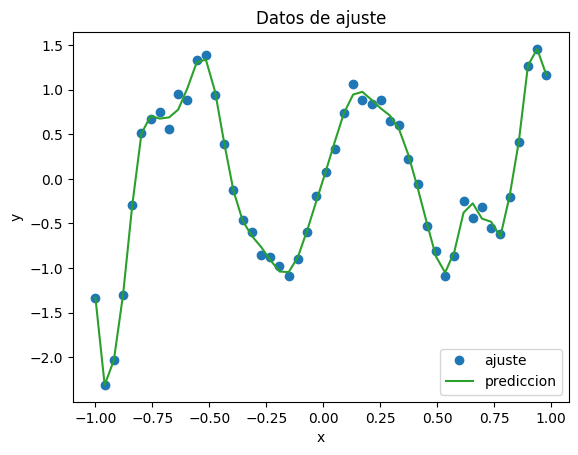

In [39]:
beta_pred, y_pred = cuadrados_minimos_svd(X_ajuste, y_ajuste, min_grado)
print('ECM de validacion sin regularizacion: ', ECM_val(beta_pred, min_grado))
print('ECM de ajuste sin regularizacion: ', ECM_ajuste(beta_pred, min_grado))

plt.plot(X_val,y_val,'o', label='validacion', color='tab:orange')
plt.plot(X_ajuste,y_pred,'-', label='prediccion', color='tab:green')
plt.title('Datos de validacion')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('graficos/sobreajuste_x_val.png')
plt.show()

plt.plot(X_ajuste,y_ajuste,'o', label='ajuste')
plt.plot(X_ajuste,y_pred,'-', label='prediccion', color='tab:green')
plt.title('Datos de ajuste')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('graficos/sobreajuste_x_ajuste.png')
plt.show()

Vemos que al utilizar el grado 32 sin regularizacion nos ajustamos mejor a los datos de ajuste que en el caso con regularizacion, pero a costo de alejarnos de los datos de validacion. Estamos teniendo un sobreajuste.

# Heatmap

Veamos la distribucion de ECM al variar los valores de grado y lambda

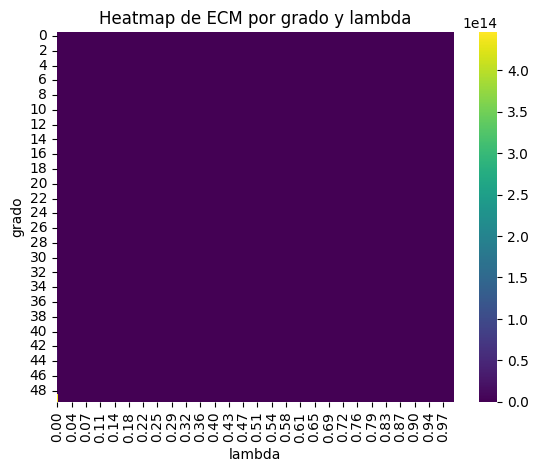

In [40]:
df = pd.DataFrame(data=resultados, index=rango_grados, columns=['%.2f' % lamb for lamb in rango_lambdas])

ax = sns.heatmap(df, cmap='viridis')
ax.set(xlabel = "lambda", ylabel = "grado")
plt.title('Heatmap de ECM por grado y lambda')
plt.show()

Esta visualizacion no nos resulta util, dado que hay ciertos grados y valores de lambda que tienen ECM muy elevado y no nos permiten visualizar los valores que nos interesan.

Para solucionarlo configuramos que el valor maximo del heatmap sea la mediana de los resultados. Esto quiere decir que cualquier ECM que este por encima de la mediana de los grados y lambdas testeados aparecera como el valor maximo.

Si bien esto no refleja fielmente las diferencias entre los valores elevados de ECM, nos permitira apreciar en mejor detalle las diferencias en los valores bajos de ECM que son los que nos interesan.

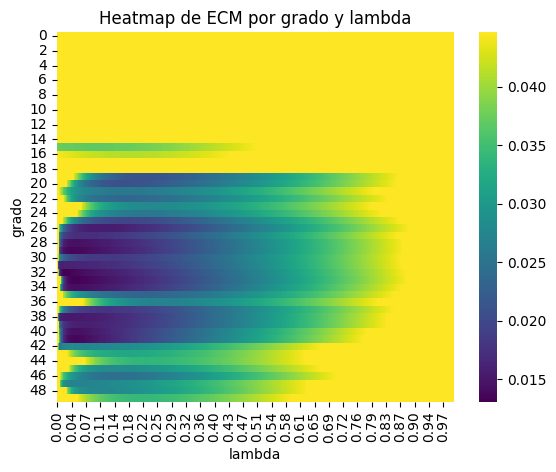

In [41]:
df = pd.DataFrame(data=resultados, index=rango_grados, columns=['%.2f' % lamb for lamb in rango_lambdas])

ax = sns.heatmap(df, cmap='viridis', vmax=np.median(resultados))
ax.set(xlabel = "lambda", ylabel = "grado")
plt.title('Heatmap de ECM por grado y lambda')
plt.savefig('graficos/grado_lambda_heatmap.png')
plt.show()

Vemos que para grados menores a 18 los ECM son muy elevados, al igual que para valores superiores a 42. Tambien vemos que los lambdas parecen tener mayor impacto en la parte inferior del rango que habiamos establecido.

Probemos entonces realizar el mismo experimento pero acotando los grados a $[18,42)$ y los lambdas a $[0, 0.25)$

In [42]:
rango_grados_acotado = np.arange(18,42)
rango_lambdas_acotado = np.linspace(0, 0.25, 1000)

resultados_acotado, min_grado_acotado, min_lamb_acotado, _ = minimizar_lambda_grado(rango_grados_acotado, rango_lambdas_acotado)

Utilizamos el mismo metodo de configurar el valor maximo en la mediana

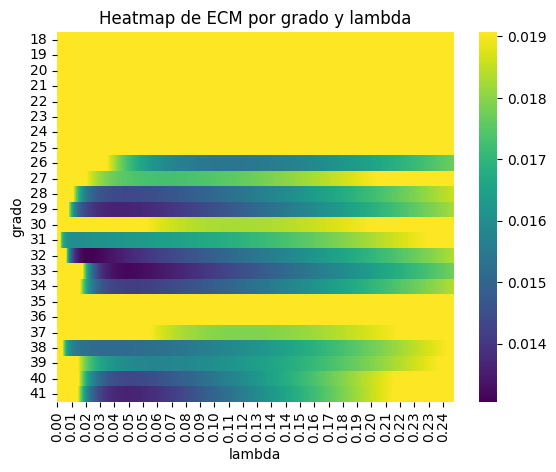

In [43]:
df = pd.DataFrame(data=resultados_acotado, index=rango_grados_acotado, columns=['%.2f' % lamb for lamb in rango_lambdas_acotado])

ax = sns.heatmap(df, cmap='viridis', vmax=np.median(resultados_acotado))
ax.set(xlabel = "lambda", ylabel = "grado")
plt.title('Heatmap de ECM por grado y lambda')
plt.show()

Aqui podemos observar mejor que los valores de lambda que mejoran el ECM varian dependiendo del grado, pero siempre tienen forma de campana invertida, empezando con un ECM elevado, alcanzando un minimo y luego volviendo a crecer.

Podemos observar este fenomeno mirando como se comporta el ECM de validacion para algunos grados al variar el lambda. Acotamos el eje $y$ del grafico para poder mostrar la tendencia creciente despues de alcanzar un minimo.

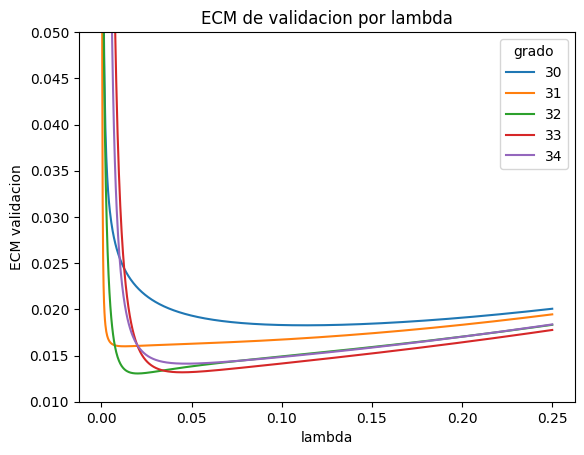

In [44]:
grados = [12,13,14,15,16]
for grado in grados:
    plt.plot(rango_lambdas_acotado, resultados_acotado[grado, :], label=grado+18)

plt.xlabel('lambda')
plt.legend(title='grado')
plt.ylim(top=0.05, bottom=0.01)
plt.ylabel('ECM validacion')
plt.title('ECM de validacion por lambda')
plt.savefig('graficos/curva_ECM.png')
plt.show()

Vemos que el ECM decrece rapidamente, alcanza un minimo y luego comienza a crecer.